# Experiment 4#

Train on Food101 image with size 512x512 use ResNet50 model without data augmentation

In [ ]:
import zipfile
import os

files = zipfile.ZipFile('MyFiles/auto_upload_20210415141331/food101.zip', 'r')
files.extractall(os.getcwd())
files.close()  

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# imports
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import seaborn as sns

In [3]:
path = Path('food101')
path_meta = path /'meta'
path_images = path/'images'

In [4]:
path_meta

PosixPath('food101/meta')

In [5]:
def build_data_frame(path_name, file_name, img_format = 'jpg'):
    """
    build_data_frame input the path and file name, the function will return the dataframe with two columns:
    ['label'] : image label
    ['image_file'] : image file name with directory information
    input paramters:
    path_name : path 
    file_name : file name, string
    img_format : default format is jpg
    
    return dataframe
    """
    path_file = path_name/file_name
    file_df = pd.read_csv(path_file,delimiter='/', header=None, names=['label', 'image_file'])
    file_df['image_file'] = file_df['label'].astype(str) + '/' + file_df['image_file'].astype(str) + '.'+img_format
    
    return file_df

In [6]:
train_df = build_data_frame(path_meta, 'train.txt')
test_df = build_data_frame(path_meta, 'test.txt')

In [7]:
train_df.head()

,label,image_file
0,apple_pie,apple_pie/1005649.jpg
1,apple_pie,apple_pie/1014775.jpg
2,apple_pie,apple_pie/1026328.jpg
3,apple_pie,apple_pie/1028787.jpg
4,apple_pie,apple_pie/1043283.jpg


In [8]:
bs=64
bs_512 = int(bs/4)

train_model_data = (ImageList.from_df(df=train_df,path=path_images, cols=1)\
                            .split_by_rand_pct(0.2)\
                            .label_from_df(cols=0)\
                            .transform(size=512)\
                            .databunch(bs=bs_512)\
                            .normalize(imagenet_stats))
recompute_scale_factor=True

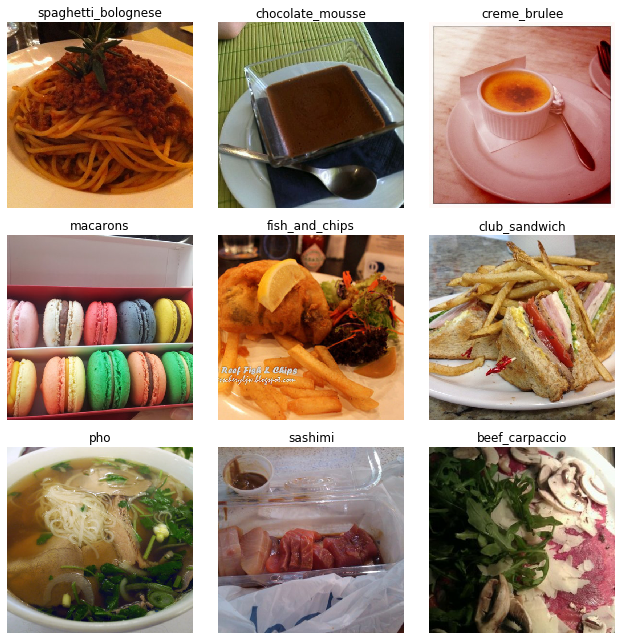

In [9]:
train_model_data.show_batch(rows=3, figsize=(9, 9))

In [10]:
top_5_accuracy = partial(top_k_accuracy, k=5)

learn = cnn_learner(train_model_data, models.resnet50, metrics=[accuracy, top_5_accuracy], callback_fns=ShowGraph)

In [11]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=101, bias=True)
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


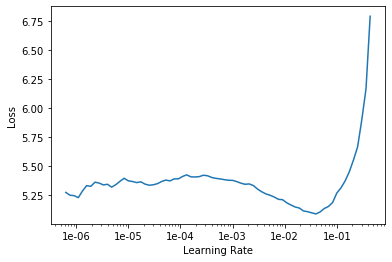

In [12]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.886969,1.488107,0.611221,0.858350,22:11
1,1.947755,1.631770,0.624950,0.859538,22:05
2,1.835679,4.817681,0.631617,0.863960,21:59
3,1.776973,3.470909,0.654587,0.873531,22:07
4,1.481589,2.044819,0.707261,0.903234,22:06
5,1.213014,1.433255,0.738746,0.919274,22:09
6,1.025145,1.637583,0.766931,0.928845,22:06
7,0.952981,1.072049,0.770297,0.929505,22:00


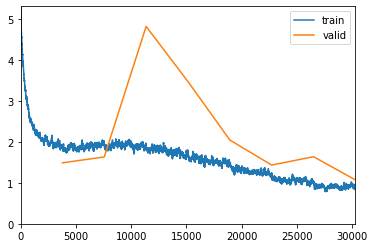

In [13]:
lr = 1e-2
learn.fit_one_cycle(8, slice(lr))
learn.save('food-101-ResNet50-512-nono')

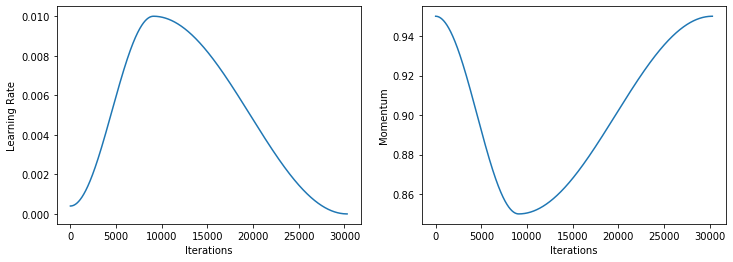

In [14]:
learn.recorder.plot_lr(show_moms=True)

# Experiment 5#

Train on Food101 image with size 512x512 use unfreeze ResNet50 model without data augmentation

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 7.59E-06


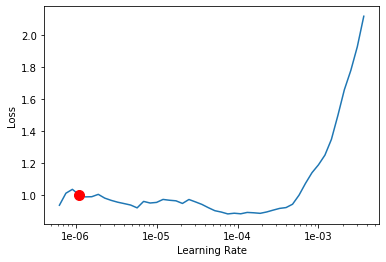

In [16]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.902453,1.202108,0.772277,0.930033,29:28
1,0.865775,0.896355,0.780528,0.938086,29:23
2,0.777556,1.052216,0.785281,0.936700,29:23
3,0.659114,1.012898,0.791683,0.937888,29:24
4,0.460571,0.937392,0.794059,0.940594,29:22
5,0.396546,0.914623,0.797492,0.940990,29:14
6,0.324474,1.135191,0.798416,0.941056,29:28
7,0.307718,0.909908,0.801452,0.941122,29:28


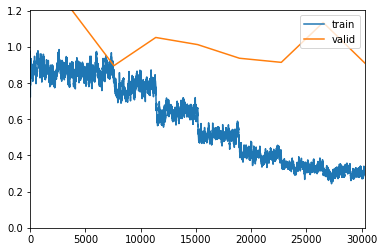

In [17]:
learn.fit_one_cycle(8, max_lr=slice(1e-6, 1e-4))
learn.save('food-101-ResNet50-512-noyes')